In [39]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Series
import networkx as nx

Gbps=1000000000

In [40]:
def getg(netg,n):
    g=[[0 for i in range (0,n)] for i in range (0,n)];
    for i in range (0,n):
        for j in netg[i]:
            g[i][j]=1
    return g
def getTotalCap(g):
    return sum(sum(g,[]))
def getdist(netg,a,b):
    return len(nx.shortest_path(netg,a,b))-1
def setDemandeven(g,nhosts,netg, hosts):
    dia=nx.diameter(netg)
    totDemand=getTotalCap(g)*Gbps/dia
    avg=totDemand/nhosts/(nhosts-1)
    outMatrix=[[0 for i in range (0,nhosts)] for i in range (0,nhosts)]
    for i in range (0,nhosts):
        for j in range (0,nhosts):
            if i!=j:
                outMatrix[i][j]=avg;
    return outMatrix

def setDemandNear(g,nhosts, netg, hosts, maph):
    outMatrix=[[0 for j in range (0,nhosts)] for i in range (0,nhosts)]
    for i in range (0,nhosts):
        for j in range (0,nhosts):
            if g[maph[i]][maph[j]]==1:
                outMatrix[i][j]=Gbps
    return outMatrix

def setDemandFar(g,nhosts,netg,hosts,maph,ratio):
    dia=nx.diameter(netg)
    outMatrix=[[0 if getdist(netg,maph[i],maph[j])<ratio*dia else 1 for j in range (0,nhosts)] for i in range (0,nhosts)]
    totDemand=getTotalCap(g)*Gbps/dia
    avg=totDemand/getTotalCap(outMatrix)
    for i in range (0,nhosts):
        for j in range (0,nhosts):
            outMatrix[i][j]=outMatrix[i][j]*avg;
    return outMatrix;    


In [41]:
import os
def printnodetype(id1, str1,f):
    f.write(" [")
    if str1=="switch":
        f.write("id=%i, \n"% (id1))
        f.write("\t\ttype=%s"% (str1))
    else:
        f.write("ip=\"0.0.%i.%i\",\n"%(int(id1/256), id1%256))
        f.write("\t\tmac=\"00:00:00:00:%i:%i\",\n"%(int(id1/100),id1%100))        
        f.write("\t\ttype=host")
    f.write("];\n")
def printlinktype(cap, dist, latency,f):
    f.write(" [")
    f.write("capacity=\"%s\", \n"%cap)
    f.write("\t\t\t\tcost=1, \n")
    f.write("\t\t\t\tdst_port=1,\n\t\t\t\tsrc_port=1")
    f.write("];\n")
def printedge(cap, dist, latency, a, b,f):
    f.write("\t%s -> %s "%(a,b))
    printlinktype(cap, dist, latency,f);
    
def printgraph(filename,g,hosts,n,names,prefix):
    f=open(filename,"w")
    f.write("strict digraph "+prefix+"{\n")
    for i in range (0, n):        
        if hosts[i]==1:
            f.write("\t%s"%(names[i]))
            printnodetype(n+i, "host",f)
        f.write("\t%s"%("s"+str(i)))
        printnodetype(i, "switch",f)        
    for i in range (0,n):
        if hosts[i]==1:
            printedge("1Gbps", 1,1, names[i], "s"+str(i),f)
            printedge("1Gbps", 1,1, "s"+str(i), names[i],f)

    for i in range (0,n):
        for j in range (0,n):
            if g[i][j]==1:
                printedge("1Gbps", 1,1, "s"+str(i),"s"+str(j),f)
                
    f.write("}") 
    f.close()
def writeMatrix(filename,m,nhosts):
    f=open(filename,"w")
    for i in range (0,20):
        for j in range (0,nhosts):
            for k in range (0,nhosts):
                f.write("%.2f "%m[j][k])
        f.write("\n")    
    f.close()
def writehosts(filename,g, hosts, n,names):
    f=open(filename,"w")
    for i in range (0,n):
        if hosts[i]==1:
            f.write("%s\n"%names[i])
    f.close()
def writeEverything(prefix, g, netg, hosts, n, nhosts, names,ratio=0.5):
    if not os.path.exists("gen"):
        os.makedirs("gen")
    printgraph("gen//"+prefix+".dot",g,hosts,n,names,prefix)
    writehosts("gen//"+prefix+".txt",g,hosts,n,names)
    writeMatrix("gen//"+prefix+"EvenDemand.txt",setDemandeven(g, nhosts, netg,hosts), nhosts)
    maph=[0]*nhosts;
    toth=0;
    for i in range(0,n):
        if hosts[i]==1:
            maph[toth]=i;
            toth=toth+1;    
    writeMatrix("gen//"+prefix+"NearDemand.txt",setDemandNear(g, nhosts, netg,hosts,maph), nhosts)
    writeMatrix("gen//"+prefix+"FarDemand.txt", setDemandFar(g, nhosts, netg,hosts,maph,ratio), nhosts)

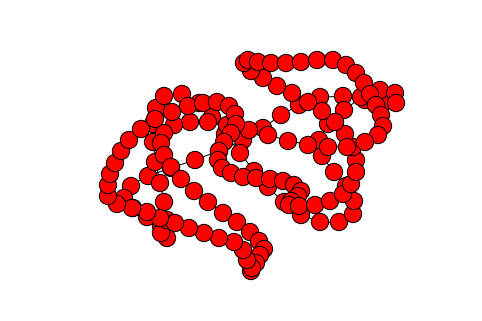

In [42]:
#get ring
def getringhost(n):
    hosts=[0]*n
    names=[""]*n
    for i in range (0, n):
        hosts[i]=1;
        names[i]="h"+str(i)        
    return hosts,names
def forring(n):
    netg=nx.cycle_graph(n)
    g=getg(netg,n)
    [hosts,names]=getringhost(n)
    nhosts=sum(hosts)
    nx.draw(netg)
    writeEverything("cycle"+str(n),g, netg, hosts, n, nhosts, names)
forring(50)
forring(100)


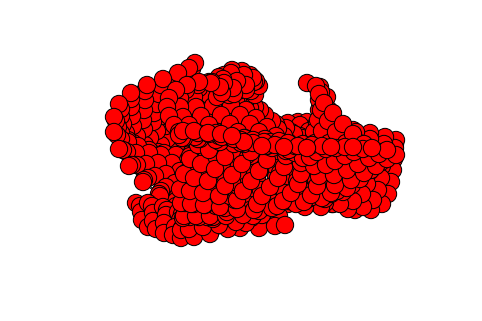

In [43]:
#get grid
import random
def getgrid(edge):
    netg=nx.Graph()
    n=edge*edge
    netg.add_nodes_from(range(0,n))
    for i in range (0,edge):
        for j in range (0,edge):
            cur=i*edge+j;
            if i>0:
                netg.add_edge(cur,cur-edge)
            if j>0:
                netg.add_edge(cur,cur-1)
            if i<edge-1:
                netg.add_edge(cur,cur+edge)
            if j<edge-1:
                netg.add_edge(cur,cur+1)
    return netg
def getgridhost(edge,n,typ):
    hosts=[0]*n
    names=[""]*n
    toth=0;
    tots=0;
    if typ==1:
        for i in range (0, n):
            if int(i/edge)==edge/2:            
                hosts[i]=1;
                names[i]="h"+str(toth)        
                toth=toth+1;
            else:
                hosts[i]=0;
                names[i]="s"+str(tots)
                tots=tots+1;
    else:
        for i in range(0,n):
            if random.uniform(0,1)>0.8:
                hosts[i]=1;
                names[i]="h"+str(toth)
                toth=toth+1;
            else:
                hosts[i]=0;
                names[i]="s"+str(tots)
                tots=tots+1;        
    return hosts,names
def forgrid(edge, typ,ratio):
    n=edge*edge
    netg=getgrid(edge)
    g=getg(netg,n)
    [hosts,names]=getgridhost(edge,n,typ)
    nhosts=sum(hosts)
    nx.draw(netg)
    writeEverything("grid"+str(edge)+"h"+str(typ),g, netg, hosts, n, nhosts, names,ratio)
forgrid(20,1,0.2)
forgrid(20,0,0.5)


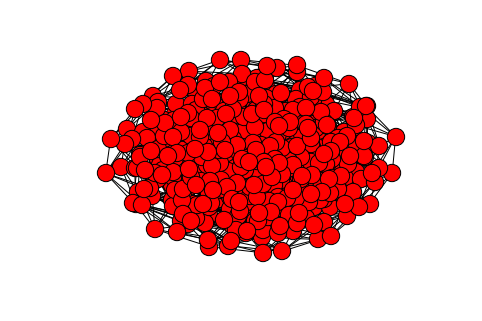

In [44]:
#get hypercube
import random
def getcube(level):    
    netg=nx.Graph()
    n=2**level
    netg.add_nodes_from(range(0,n))
    for i in range (0,n):
        for j in range (0,level):
            netg.add_edge(i,i^(2**j))                              
    return netg
def getcubehost(n,typ):
    hosts=[0]*n
    names=[""]*n
    toth=0;
    tots=0;
    if typ==1:
        for i in range (0, n):
            if i%4==0:            
                hosts[i]=1;
                names[i]="h"+str(toth)        
                toth=toth+1;
            else:
                hosts[i]=0;
                names[i]="s"+str(tots)
                tots=tots+1;
    else:
        for i in range(0,n):
            if random.uniform(0,1)>0.8:
                hosts[i]=1;
                names[i]="h"+str(toth)
                toth=toth+1;
            else:
                hosts[i]=0;
                names[i]="s"+str(tots)
                tots=tots+1;        
    return hosts,names
def forcube(level,typ,ratio):
    n=2**level
    netg=getcube(level)
    g=getg(netg,n)
    [hosts,names]=getcubehost(n,typ)
    nhosts=sum(hosts)
    nx.draw(netg)
    writeEverything("cube"+str(level)+"h"+str(typ),g, netg, hosts, n, nhosts, names,ratio)
forcube(8,1,0.5)
forcube(8,0,0.5)


9
6


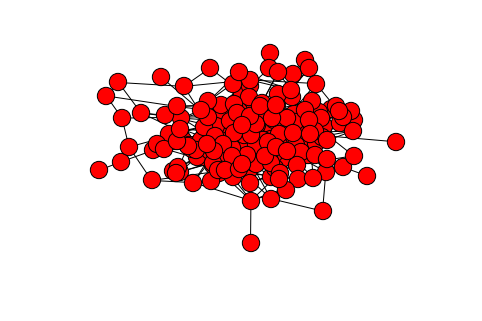

In [45]:
def getrandomhost(n):
    hosts=[0]*n
    names=[""]*n
    for i in range (0,n):
        hosts[i]=1;
        names[i]="h"+str(i)
    return hosts,names
def forgnp(n,p, ratio):
    netg=nx.gnp_random_graph(n,p)
    while nx.is_connected(netg)==False:
        netg=nx.gnp_random_graph(n,p)
    g=getg(netg,n)
    print (nx.diameter(netg))
    [hosts,names]=getrandomhost(n)
    nhosts=sum(hosts)
    nx.draw(netg)
    writeEverything("gnp"+str(n)+"pr"+str(p),g, netg, hosts, n, nhosts, names,ratio)
forgnp(100,0.03,0.5)
forgnp(100,0.05,0.5)


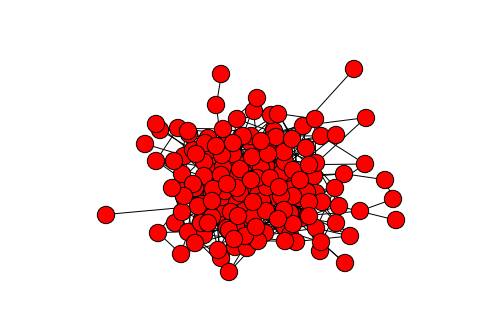

In [46]:
def forgnm(n,m, ratio):
    netg=nx.gnm_random_graph(n,m)
    while nx.is_connected(netg)==False:
        netg=nx.gnm_random_graph(n,m)
    g=getg(netg,n)
    [hosts,names]=getrandomhost(n)
    nhosts=sum(hosts)
    nx.draw(netg)
    writeEverything("gnm"+str(n)+"m"+str(m),g, netg, hosts, n, nhosts, names,ratio)
forgnm(100,200,0.5)
forgnm(100,300,0.5)


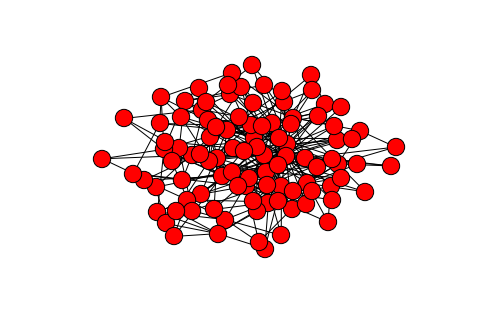

In [47]:
def forPA(n,m, ratio):
    netg=nx.barabasi_albert_graph(n,m)
    while nx.is_connected(netg)==False:
        netg=nx.barabasi_albert_graph(n,m)
    g=getg(netg,n)
    [hosts,names]=getrandomhost(n)
    nhosts=sum(hosts)
    nx.draw(netg)
    writeEverything("PA"+str(n)+"per"+str(m),g, netg, hosts, n, nhosts, names,ratio)
forPA(100,3,0.5)
